# CNN for Cifar-10 Dataset

## Requirements

For this project we are used:
* Python 3.6
* Tensorflow 1.8.0
    * *Suite of visualization tools* Tensorboard
    * *Profiler* Tensorflow profiler
* Perf and Pyperf
* Graphviz *drawing graphs tool*
* *GPUs parallel calculation manager* nVidia CUDA 9.0
* *GPU-accelerated library* nVidia cuDNN 7.1

## Introduction

In this first notebook we are going to explain how we have set up our work.  
Essentially the process is divided into several parts:
* Set up environment with the Cifar-10 Dataset
* Define a convolutional neural network
* Define a quantization method
* Train the convolutional neural network
* Provide information about CNN's performance and accuracy

In [1]:
import numpy as np
import tensorflow as tf

C:\Users\Davide\Anaconda3\envs\tfp3.6\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Cifar-10 Dataset

Cifar-10 Dataset is taken from the official website www.cs.toronto.edu.

Dataset is stored in the data directory: cnn/data. From Cifar-10 dataset we are going to take x_train, t_train, x_test and t_test.
The training dataset set is used for training the CNN, the testing dataset is used for evaluate the performance and the accuracy of the network.

### Load data

In [2]:
from cnn.utils.dataset import load_cifar10, dataset_preprocessing_by_keras

In [3]:
x_train, t_train, x_test, t_test = load_cifar10()

In [4]:
x_train.shape, t_train.shape, x_test.shape, t_test.shape

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

In [5]:
x_train = dataset_preprocessing_by_keras(x_train)
x_train[0, :, :, 0]

array([[-0.68747891, -0.65572952, -0.63985482, ..., -0.95734874,
        -1.00497283, -0.92559935],
       [-0.65572952, -0.63985482, -0.59223073, ..., -0.92559935,
        -1.02084753, -0.86210057],
       [-0.7192283 , -0.63985482, -0.65572952, ..., -0.68747891,
        -0.735103  , -0.70335361],
       ...,
       [-0.36998499, -0.7509777 , -1.00497283, ..., -0.25886212,
        -0.24298742, -0.14773924],
       [-0.25886212, -0.65572952, -1.19546919, ...,  0.31262694,
        -0.00486698, -0.49698256],
       [-0.27473681, -0.35411029, -1.11609571, ...,  0.75711843,
         0.64599556,  0.28087755]])

## CNN Model and Training

First of all it's better to clean our */tmp/log-tb/* * folder by running this code:

In [6]:
import os
import shutil

try:
    shutil.rmtree("/tmp/log-tb/*")
except:
    pass

We will use a custom made wrapper for tensorflow NN training and use.

In [7]:
from cnn.model_class import TfClassifier

In this notebook we are going to analyze the Dense net: CNN is called *dense_cnn*. Here we will explain how it is composed.

The CNN is composed by several layers. In the first part there are 2 **convolutional** layers and 2 **pooling** layers (they are alternated), then there are a *flatten* layer followed by a **relu** layer, a *dropout* layer and finally a **softmax** layer.

The network uses a stochastic gradient descent optimizer and a categorical crossentropy loss.  
To judge the performance of our model we are used a MSE metric.

In [8]:
from cnn.dense import NET_NAME, eval_fn, forward_pass, loss_fn
from cnn.model_class import TfClassifier

In [9]:
model = TfClassifier(NET_NAME, forward_pass, loss_fn, eval_fn,
                     tf.train.AdamOptimizer())

This is just an example: network is trained for 1 epoch.

In [10]:
history = model.fit(
   [x_train, t_train],
   batch_size=64,
   validation_split=0.1,
   epochs=1,
   verbosity=1,
   drop_prob=0.5)

print(history)

For training: tensorboard --logdir=/tmp/log-tb/dense/training
For validation: tensorboard --logdir=/tmp/log-tb/dense/validation
{'accuracy': ((0.586, 0.5884),), 'loss': (1.173607,)}


Then it's evaluated.

In [11]:
x_test = dataset_preprocessing_by_keras(x_test)
evals = model.evaluate([x_test, t_test])

print(evals)

INFO:tensorflow:Restoring parameters from C:/Users/Davide/Desktop/CNN/ACAR/cnn/models/dense/model.ckpt
[{'logits': array([[-0.5111809 , -3.4625082 ,  0.287709  , ..., -0.4058437 ,
        -1.7331388 , -2.3973126 ],
       [-1.5883482 , -4.383567  ,  0.45027995, ...,  0.5975137 ,
        -3.5946252 , -2.8315969 ],
       [ 2.472421  , -0.71238214, -0.21340908, ..., -1.9722563 ,
         3.836227  , -0.7319518 ],
       ...,
       [-3.303174  , -3.291129  ,  0.86017674, ...,  2.7280533 ,
        -4.9365764 , -3.2929118 ],
       [-0.9464673 , -0.80680394,  0.42229223, ...,  0.14775734,
        -0.8692442 , -1.5623072 ],
       [-0.735885  , -3.2656732 ,  1.5882425 , ...,  0.43041545,
        -0.8183454 , -1.4541456 ]], dtype=float32), 'classes': array([4, 3, 8, ..., 4, 3, 5], dtype=int64), 'probabilities': array([[3.6447641e-02, 1.9051284e-03, 8.1025705e-02, ..., 4.0496431e-02,
        1.0739393e-02, 5.5275513e-03],
       [4.4862456e-03, 2.7411646e-04, 3.4454670e-02, ..., 3.9920032e-02

## Tensorboard Results

Here's a function made by us that plot tags data got from the last tensorboard session.

In [12]:
import matplotlib.pyplot as plt
import glob

'''Fn that plot tags data got from the last tensorboard session
param: is the tag that the function will look for in the output file generated by tensorflow
source: there are only two options of source, training or validation'''
def plot_from_tensorfboard (param, source):
    files_in_dir = len(glob.glob("/tmp/log-tb/" + NET_NAME + "/" + source + "/*"))
    values = []
    for e in tf.train.summary_iterator(glob.glob("/tmp/log-tb/" + NET_NAME + "/" + source + "/*")[files_in_dir - 1]):
        for v in e.summary.value:
            if v.tag == param:
                values.append(v.simple_value)
    values = np.array(values)
    plt.plot(values)
    plt.show()

### Generated graphs

The graphs generated by tensorflow must be interpreted in this way:  
Axis of the ordinates: Tag (param) value;  
Axis of the abscissas:
* *Training* graphs: Training Step
* *Validation* graphs: Epoch

Here's **loss** data plot, got from Tensorboard, for *training*:

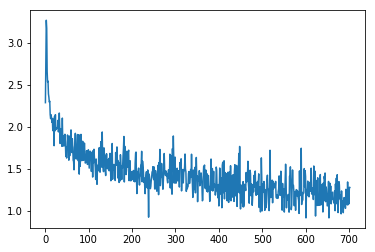

In [13]:
plot_from_tensorfboard('loss','training')

Here's **loss** data plot, got from Tensorboard, for *validation*:

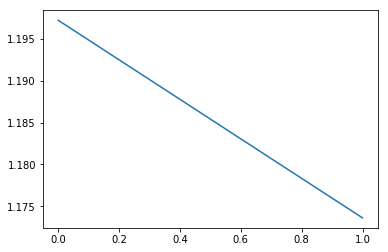

In [14]:
plot_from_tensorfboard('loss','validation')

Here's **accuracy** data plot, got from Tensorboard, for *training*:

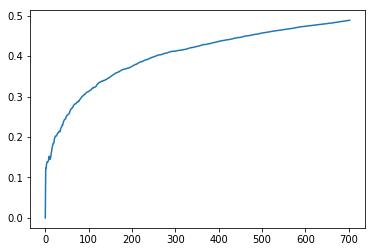

In [15]:
plot_from_tensorfboard('accuracy_1','training')

Here's **accuracy** data plot, got from Tensorboard, for *validation*:

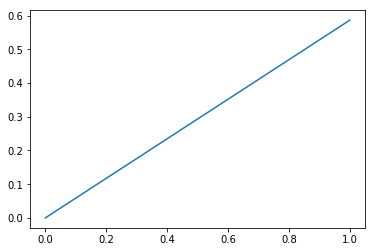

In [16]:
plot_from_tensorfboard('accuracy_1','validation')

We can also take a look of the **Model graph** using the *Graphviz* drawing tool

Firstly we have to create a DOT file from the PB model graph file.

In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import re
from google.protobuf import text_format
from tensorflow.core.framework import graph_pb2

def convert_graph_to_dot(input_graph, output_dot, is_input_graph_binary):
    graph = graph_pb2.GraphDef()
    with open(input_graph, "rb") as fh:
        if is_input_graph_binary:
            graph.ParseFromString(fh.read())
        else:
            text_format.Merge(fh.read(), graph)
    with open(output_dot, "wt") as fh:
        print("digraph graphname {", file=fh)
        for node in graph.node:
            output_name = node.name
            print("  \"" + output_name + "\" [label=\"" + node.op + "\"];", file=fh)
            for input_full_name in node.input:
                parts = input_full_name.split(":")
                input_name = re.sub(r"^\^", "", parts[0])
                print("  \"" + input_name + "\" -> \"" + output_name + "\";", file=fh)
        print("}", file=fh)
        print("Created dot file '%s' for graph '%s'." % (output_dot, input_graph))

input_graph='./cnn/models/dense_cnn/model.pb'
output_dot='./cnn/models/dense_cnn/model.dot'
convert_graph_to_dot(input_graph=input_graph, output_dot=output_dot, is_input_graph_binary=True)

/home/m/myvenv3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Created dot file './cnn/models/dense_cnn/model.dot' for graph './cnn/models/dense_cnn/model.pb'.


Now using *bash* and *dot command*, included in *Grapviz*, we can create a PNG file from the DOT file just created

In [1]:
%%bash

dot -T png ./cnn/models/dense_cnn/model.dot \
    -o ./cnn/models/dense_cnn/model.png > /tmp/a.out

Finally we can visualize the PNG file using *IPhthon*

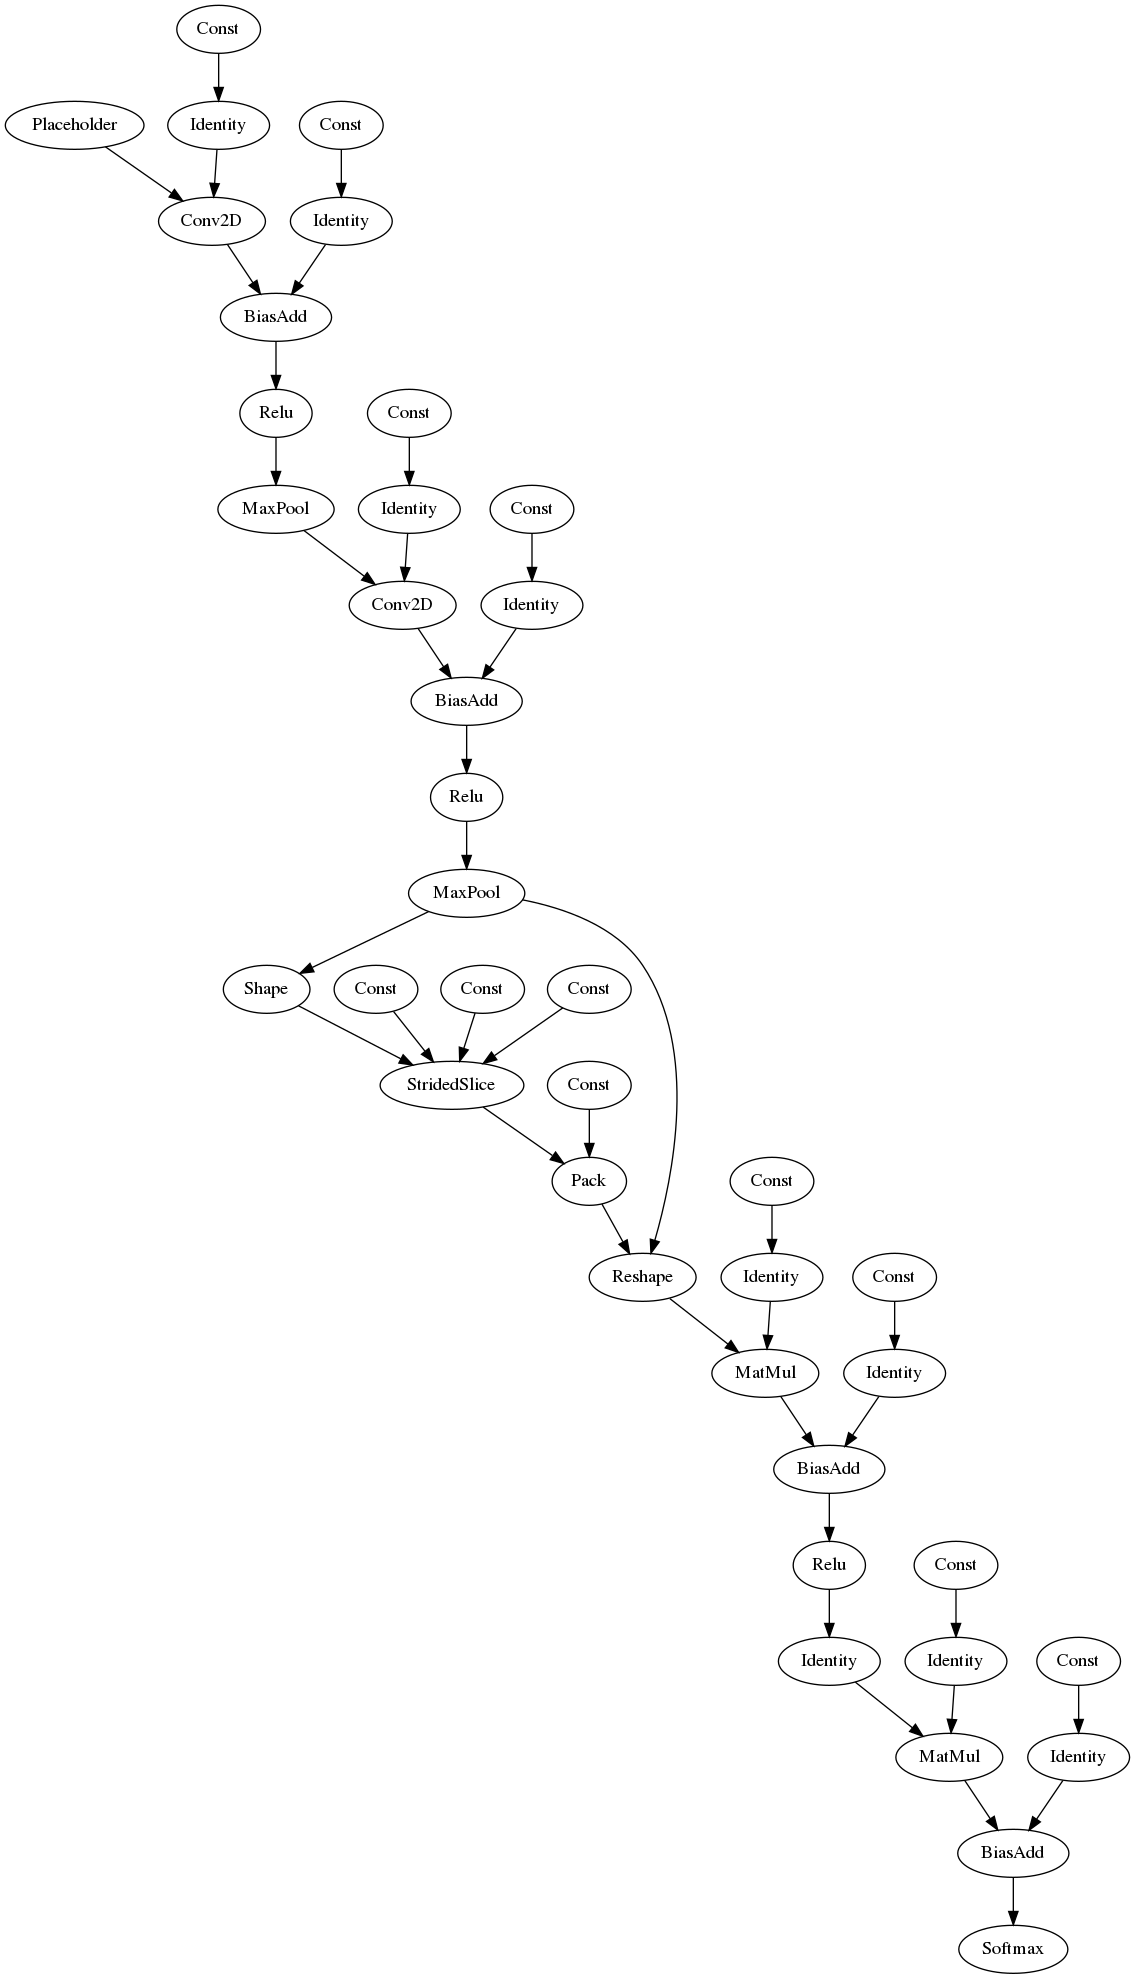

In [3]:
from IPython.display import Image

Image('./cnn/models/dense_cnn/dense_cnn.png', width=1024, height=768)